In [1]:
# import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# set up relative paths
path = os.path.dirname('')
task_2_dir = os.path.join(path, '..', 'task_2')

# import dataset as panda dataframes
approved = pd.read_csv(os.path.join(task_2_dir, 'approved_drugs.csv'), index_col = 0)
spike = pd.read_csv(os.path.join(task_2_dir, 'spike_positive_compounds.csv'), index_col = 0)

# Find out the data types of the features in each df
print('datatypes by features in approved dataset:\n',approved.dtypes)
print('datatypes by features in spike dataset:\n',spike.dtypes)


datatypes by features in approved dataset:
 feature_1     object
feature_2    float64
feature_3    float64
dtype: object
datatypes by features in spike dataset:
 feature_1     object
feature_2    float64
feature_3    float64
dtype: object


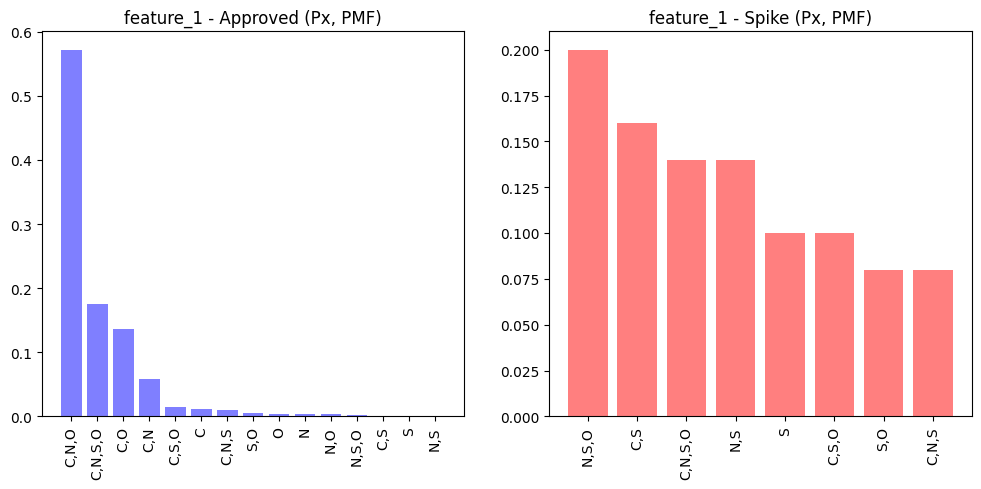

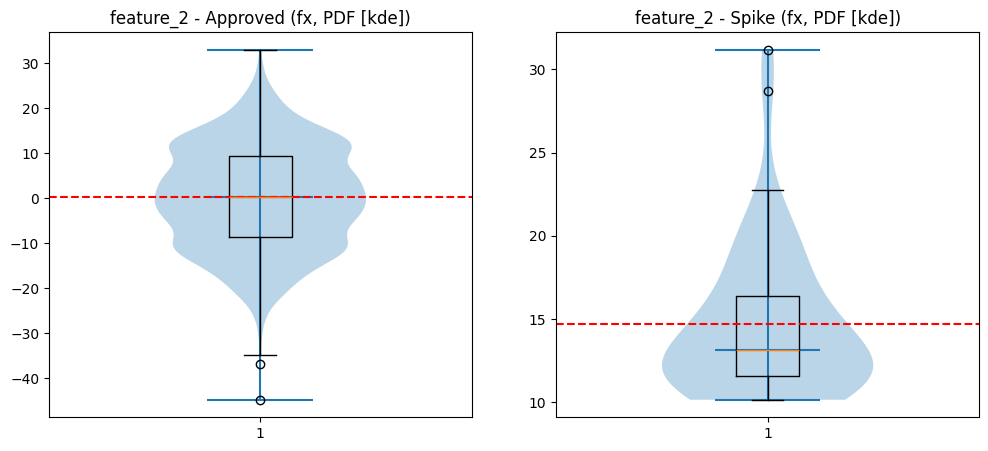

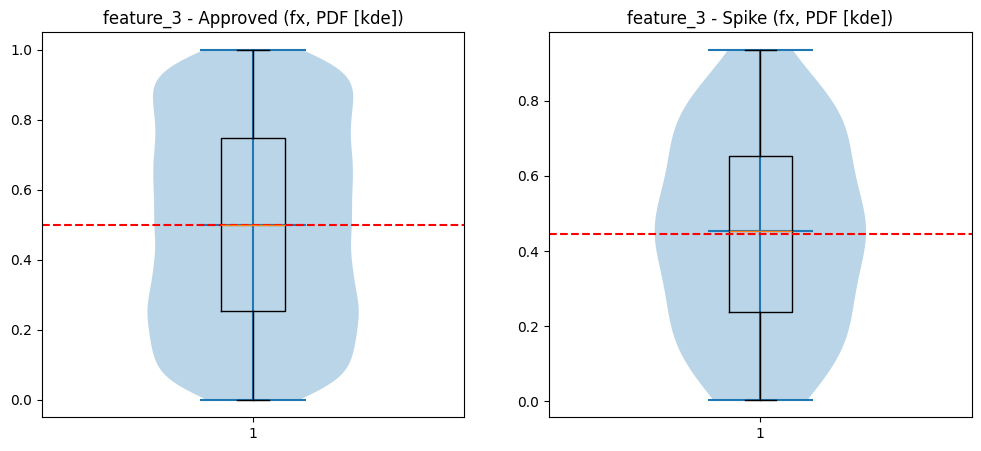

In [3]:
#  Plot probability distributions for each feature in each dataset

def plot_proba(feature1, feature2, name):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Creating side-by-side plots

    if feature1.dtype == 'O':  # Categorical feature, probability mass function (PMFs) plots
        # Calculate the probability for each feature
        probs1 = feature1.value_counts() / feature1.shape[0]
        probs2 = feature2.value_counts() / feature2.shape[0]

        # plot the PMFs by feature for each dataframe
        ax[0].bar(probs1.index, probs1, color='blue', alpha=0.5, label="Approved")
        ax[1].bar(probs2.index, probs2, color='red', alpha=0.5, label="Spike")
        ax[0].set_title(f"{name} - Approved (Px, PMF)")
        ax[1].set_title(f"{name} - Spike (Px, PMF)")
        ax[0].set_xticks(range(len(probs1.index)))  
        ax[0].set_xticklabels(probs1.index, rotation=90)
        ax[1].set_xticks(range(len(probs2.index)))
        ax[1].set_xticklabels(probs2.index, rotation=90)
        
    else:  # Scalar feature, use matplotlib kde estimates (overlayed with boxplot) of probabiity density function (PDF) plots

        # Plot the PDFs (violin) with boxplot overlay by feature for each dataframe
        ax[0].violinplot(feature1.dropna(), showmedians=True)
        ax[0].boxplot(feature1.dropna())
        ax[0].set_title(f"{name} - Approved (fx, PDF [kde])")
        ax[0].axhline(feature1.mean(), linestyle = '--', color = 'red')
        ax[1].violinplot(feature2.dropna(), showmedians=True)
        ax[1].boxplot(feature2.dropna())
        ax[1].axhline(feature2.mean(), linestyle = '--', color = 'red')
        ax[1].set_title(f"{name} - Spike (fx, PDF [kde])")

    plt.show()

# Apply the function for each common column in approved and spike datasets
for col in approved.columns:
    if col in spike.columns:
        plot_proba(approved[col], spike[col], col)

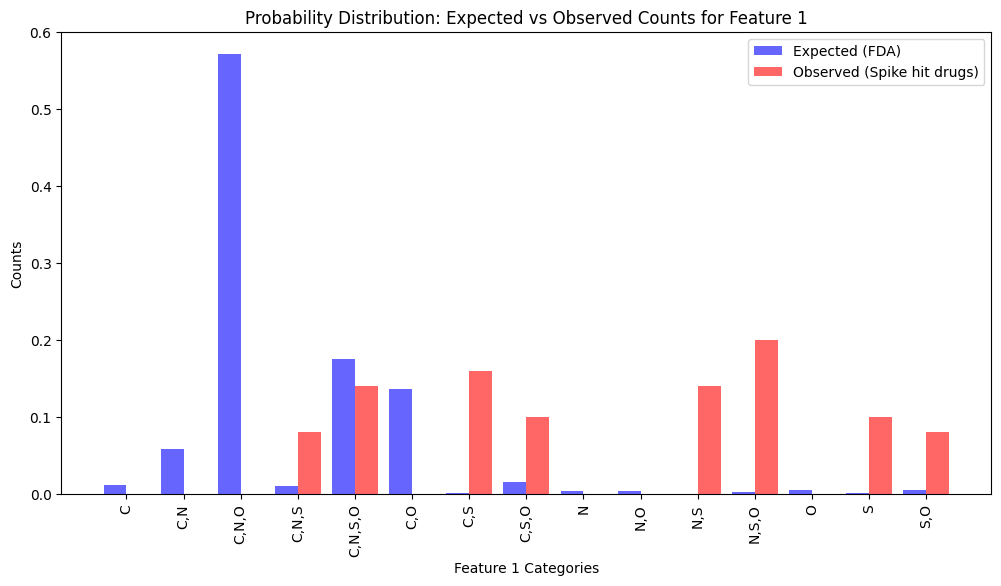


Feature_1 *is significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = 7197.5002188622575

Feature_1 *is significantly different* (at alpha = 0.01) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = 7197.5002188622575


In [ ]:
# FEATURE 1: chi squared test on feature 1, spike vs approved

# extract value counts of feature_1 items in approved dataset
approved_counts = approved['feature_1'].value_counts().rename('population')

# extract value counts of feature_1 items in spike dataset 
spike_counts = spike['feature_1'].value_counts().rename('observed')

# inner merge to get shared features only for chi squared test and create a contingency table for the test
contig_df = pd.merge(approved_counts, spike_counts, left_index = True, right_index = True, how = 'outer').fillna(0)

# create population probability (ratios of feature_1 outcomes in approved dataset) to model the population
contig_df['population_proba'] = contig_df['population']/contig_df['population'].sum()

# generate expected counts based on population probability 
contig_df['expected'] = contig_df['population_proba'] * contig_df['observed'].sum()

# Plot the probability mass functions side by side
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(contig_df.index))
plt.bar(x - bar_width/2, contig_df['expected']/contig_df['expected'].sum(), width=bar_width, color='blue', alpha=0.6, label='Expected (FDA)')
plt.bar(x + bar_width/2, contig_df['observed']/contig_df['observed'].sum(), width=bar_width, color='red', alpha=0.6, label='Observed (Spike hit drugs)')
plt.xticks(x, contig_df.index, rotation=90)
plt.xlabel("Feature 1 Categories")
plt.ylabel("Counts")
plt.title("Probability Distribution: Expected vs Observed Counts for Feature 1")
plt.legend()
plt.show()

def alpha_crit(stat, pvalue, alpha, featname): # Type I error control function
    if pvalue < 0.01:
        pvalue = 1e-10 if pvalue < 1e-10 else str(pvalue) # float error control for super small p-values
        print(f'\n{featname} *is significantly different* (at alpha = {alpha}) \nin spike data set vs approved dataset, with p-value = {pvalue} & \ntest statistic = {stat}')
    else:
        print(f'\n{featname} *is not significantly different* (at alpha = {alpha}) \nin spike data set vs approved dataset, with p-value = {pvalue} & \ntest statistic = {stat}')

# apply chisquare test using expected counts (modelled from FDA drugs) and observed count (spike protein responsive drugs)
chistat, pvalue = scipy.stats.chisquare(f_obs=contig_df['observed'], f_exp=contig_df['expected'])

# set an array of alphas to test
alphas = np.array([0.05, 0.01])

# report chi square test results
for alpha in alphas:
    alpha_crit(stat = chistat, pvalue = pvalue, alpha = alpha, featname = 'Feature_1')

In [ ]:
# two-tailed, two-sample independent t-test on feature 2, spike vs approved

# prints summary statistics
print(f"Approved drug dataset, summary statistics:\n{approved['feature_2'].describe()}\n"
      f"Spike drug dataset, summary statistics:\n{spike['feature_2'].describe()}")

# performs test
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_2'], spike['feature_2'], equal_var = False)

# reports test
for alpha in alphas:
    alpha_crit(stat = tstat, pvalue = pvalue, alpha = alpha, featname = 'Feature_2')


Approved drug dataset, summary statistics:
count    4913.000000
mean        0.207669
std        11.525513
min       -44.852145
25%        -8.750197
50%         0.234278
75%         9.464845
max        32.993710
Name: feature_2, dtype: float64
Spike drug dataset, summary statistics:
count    50.000000
mean     14.705413
std       4.528186
min      10.146325
25%      11.600307
50%      13.110948
75%      16.387991
max      31.173711
Name: feature_2, dtype: float64

Feature_2 *is significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = -21.92787245790435

Feature_2 *is significantly different* (at alpha = 0.01) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = -21.92787245790435


In [ ]:
# two-tailed, two-sample independent t-test on feature 3, spike vs approved

# prints summary statistics
print(f"Approved drug dataset, summary statistics:\n{approved['feature_3'].describe()}\n"
      f"Spike drug dataset, summary statistics:\n{spike['feature_3'].describe()}")

# performs test
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_3'], spike['feature_3'], equal_var=True)

# reports test
for alpha in alphas:
    alpha_crit(stat = tstat, pvalue = pvalue, alpha = alpha, featname = 'Feature_3')

Approved drug dataset, summary statistics:
count    4913.000000
mean        0.499595
std         0.287415
min         0.000132
25%         0.252323
50%         0.499155
75%         0.748173
max         0.999910
Name: feature_3, dtype: float64
Spike drug dataset, summary statistics:
count    50.000000
mean      0.445801
std       0.257356
min       0.004005
25%       0.236710
50%       0.453964
75%       0.652877
max       0.935747
Name: feature_3, dtype: float64

Feature_3 *is not significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 0.18754569271266547 & 
test statistic = 1.3180561927968157

Feature_3 *is not significantly different* (at alpha = 0.01) 
in spike data set vs approved dataset, with p-value = 0.18754569271266547 & 
test statistic = 1.3180561927968157


In [ ]:
# feature 1 test (full)
chistat, pvalue = scipy.stats.chisquare(f_obs=contig_df['observed'], f_exp=contig_df['expected'])
alpha_crit(stat = chistat, pvalue = pvalue, alpha = 0.05, featname = 'Feature_1')
# feature 2 test (full)
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_2'], spike['feature_2'], equal_var = False)
alpha_crit(stat = tstat, pvalue = pvalue, alpha = 0.05, featname = 'Feature_2')
# feature 3 test (full)
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_3'], spike['feature_3'], equal_var = True)
alpha_crit(stat = tstat, pvalue = pvalue, alpha = 0.05, featname = 'Feature_3')


Feature_1 *is significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = 7197.5002188622575

Feature_2 *is significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 1e-10 & 
test statistic = -21.92787245790435

Feature_3 *is not significantly different* (at alpha = 0.05) 
in spike data set vs approved dataset, with p-value = 0.18754569271266547 & 
test statistic = 1.3180561927968157
